In [204]:
import pandas as pd
import numpy as np
import requests
import json
import re
import seaborn as sns
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [164]:
# distinguish between actively managed and passively managed mutual funds

def managed(expense_ratio):
    if expense_ratio < 0.007:
        return 'passive'
    else:
        return 'active'

# get all historical price data from yahoo finance

def get_price(ticker):

    url = 'https://finance.yahoo.com/quote/{}/history?'.format(ticker)
    params = {'interval':'1d', 
              'filter':'history', 
              'frequency':'1d'}
    
    r = requests.get(url, params=params)

    try:
        txt = re.search(r'root\.App\.main = (.*?);\n}\(this\)\);', r.text, re.DOTALL).group(1)
        jsn = json.loads(txt)
        prcs = pd.DataFrame(jsn['context']['dispatcher']['stores']['HistoricalPriceStore']['prices'])
        prcs['date'] = pd.to_datetime(prcs['date'], unit='s')
        prcs['date'] = pd.DatetimeIndex(prcs['date']).normalize()
        prcs = prcs[['open', 'high', 'low', 'close', 'adjclose', 'volume']]
        prcs = prcs.dropna(how='all').sort_index()
    except:
        prcs = pd.DataFrame(columns=['open', 'high', 'low', 'close', 
                                     'adjclose', 'volume'])
    
    return prcs

# takes in dictionary where key = Fund Ticker and value is a dataframe with price data

def df_date_range(pricing_data):
    start = '01/01/2015'
    end = '01/01/2015'

    for k in pricing_data:
        dfs = pricing_data.get(k)
        if dfs['date'].min() < start: start = dfs['date'].min() 
        if dfs['date'].max() > end: end = dfs['date'].max() 
        index = pd.date_range(start, end)
        return pd.DataFrame(index)



In [165]:
data = pd.read_csv('crsp.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (45,47,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [166]:
data.shape

(458503, 70)

In [167]:
data.columns

Index(['summary_period2', 'crsp_fundno', 'caldt', 'nav_latest',
       'nav_latest_dt', 'tna_latest', 'tna_latest_dt', 'yield', 'div_ytd',
       'cap_gains_ytd', 'nav_52w_h', 'nav_52w_h_dt', 'nav_52w_l',
       'nav_52w_l_dt', 'unrealized_app_dep', 'unrealized_app_dt', 'asset_dt',
       'per_com', 'per_pref', 'per_conv', 'per_corp', 'per_muni', 'per_govt',
       'per_oth', 'per_cash', 'per_bond', 'per_abs', 'per_mbs', 'per_eq_oth',
       'per_fi_oth', 'maturity', 'maturity_dt', 'cusip8', 'crsp_portno',
       'crsp_cl_grp', 'fund_name', 'ticker', 'ncusip', 'mgmt_name', 'mgmt_cd',
       'mgr_name', 'open_to_inv', 'retail_fund', 'inst_fund', 'm_fund',
       'index_fund_flag', 'vau_fund', 'et_flag', 'delist_cd', 'end_dt',
       'dead_flag', 'merge_fundno', 'actual_12b1', 'max_12b1', 'exp_ratio',
       'mgmt_fee', 'turn_ratio', 'fiscal_yearend', 'crsp_obj_cd', 'si_obj_cd',
       'accrual_fund', 'sales_restrict', 'wbrger_obj_cd', 'policy',
       'lipper_class', 'lipper_class_name'

In [168]:
df = pd.DataFrame({'Fund Name' : data['fund_name'], 'Fund Ticker' : data['ticker'], 
                   'Open to Investors' : data['open_to_inv'], 'Expense Ratio' : data['exp_ratio'],
                  'Management Fee' : data['mgmt_fee']})

In [169]:
df.isnull().sum()

Expense Ratio        73112
Fund Name             4731
Fund Ticker          60938
Management Fee       73220
Open to Investors     6101
dtype: int64

In [170]:
df.dropna(inplace = True)

In [171]:
df['Active or Passive'] = df['Expense Ratio'].apply(managed)

In [172]:
df = df[df['Open to Investors'] == 'Y']

In [173]:
df = df[df['Management Fee'] > 0]

In [174]:
df = df[df['Expense Ratio'] > 0]

In [175]:
df.drop_duplicates(subset = ['Fund Ticker'], inplace = True)

In [176]:
df.shape

(39305, 6)

In [177]:
df.head(5)

,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Active or Passive
7,0.0242,American Pension Investors Trust: Growth Fund,APITX,0.863,Y,active
44,0.0185,UAM Funds Trust: BHM&S Total Return Bond Portf...,BHMSX,1.223,Y,active
46,0.0081,UAM Funds Trust: Chicago Asset Management Inte...,CAMBX,0.220,Y,active
58,0.0090,The DLB Fund Group: DLB Enterprise III Fund,DLBCX,0.503,Y,active
61,0.0162,"UAM Funds, Inc.: DSI Balanced Portfolio; Insti...",DSIZX,1.138,Y,active


In [178]:
df['Active or Passive'].value_counts()

active     30711
passive     8594
Name: Active or Passive, dtype: int64

In [179]:
df.head()

,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Active or Passive
7,0.0242,American Pension Investors Trust: Growth Fund,APITX,0.863,Y,active
44,0.0185,UAM Funds Trust: BHM&S Total Return Bond Portf...,BHMSX,1.223,Y,active
46,0.0081,UAM Funds Trust: Chicago Asset Management Inte...,CAMBX,0.220,Y,active
58,0.0090,The DLB Fund Group: DLB Enterprise III Fund,DLBCX,0.503,Y,active
61,0.0162,"UAM Funds, Inc.: DSI Balanced Portfolio; Insti...",DSIZX,1.138,Y,active


In [ ]:
pricing_data = {}

for fund in df['Fund Ticker']:
    try:
        pricing_data[fund] = get_price(fund)
        time.sleep(10)
    except:
        print('Failed to get data for: ' + fund)
        time.sleep(10)

In [ ]:
pricing_data.to_csv('Pricing_Data.csv')

In [ ]:
returns = df_date_range(pricing_data)

In [ ]:
for k in pricing_data:
    dfs = pricing_data.get(k)
    returns[k] = np.where(returns['date'] == dfs['date'], dfs['close'], 0)

In [ ]:
returns

In [ ]:
#sent['f6mret'] = sent['sp500'].shift(-26) / sent['sp500'] -1
#sent['f1yret'] = sent['sp500'].shift(-52) / sent['sp500'] -1
#sent['l6mret'] = sent['sp500'] / sent['sp500'].shift(26) -1
#sent['l1yret'] = sent['sp500'] / sent['sp500'].shift(52) -1

In [251]:
df.head()

,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Active or Passive
7,0.0242,American Pension Investors Trust: Growth Fund,APITX,0.863,Y,active
44,0.0185,UAM Funds Trust: BHM&S Total Return Bond Portf...,BHMSX,1.223,Y,active
46,0.0081,UAM Funds Trust: Chicago Asset Management Inte...,CAMBX,0.220,Y,active
58,0.0090,The DLB Fund Group: DLB Enterprise III Fund,DLBCX,0.503,Y,active
61,0.0162,"UAM Funds, Inc.: DSI Balanced Portfolio; Insti...",DSIZX,1.138,Y,active


In [252]:
df.describe()

,Expense Ratio,Management Fee
count,39305.000000,39305.000000
mean,0.012422,0.567159
std,0.007399,0.464915
min,0.000100,0.001000
25%,0.007500,0.305000
50%,0.011600,0.550000
75%,0.016700,0.769000
max,0.531200,36.108000


In [181]:
active = df['Active or Passive'].value_counts()[0]
passive = df['Active or Passive'].value_counts()[1]

total = active + passive
act = round(100*(active/total),2)
pas = round(100*(passive/total),2)


print('There are {} ({}%) actively managed mutual funds'.format(active, act))
print('There are {} ({}%) passively managed mutual funds'.format(passive, pas))





There are 30711 (78.14%) actively managed mutual funds
There are 8594 (21.86%) passively managed mutual funds


In [182]:
df['Management Fee'].min()

0.001

In [183]:
df['Management Fee'].max()

36.108

In [184]:
df['Management Fee'].mean()

0.567158911080022

In [185]:
total_active = []
total_passive = []
row = 0
for act in df['Active or Passive']:
    if act == 'active':
        total_active.append(df['Management Fee'].iloc[row])
    else:
        total_passive.append(df['Management Fee'].iloc[row])
    row += 1



In [186]:
sum_active = sum(total_active)
sum_passive = sum(total_passive)


In [187]:
avg_active = round(sum_active/active,2)
avg_passive = round(sum_passive/passive,2)

In [188]:
print('Average management fee for actively managed funds: {}%'.format(avg_active))
print('Average management fee for passively managed funds: {}%'.format(avg_passive))

Average management fee for actively managed funds: 0.65%
Average management fee for passively managed funds: 0.28%


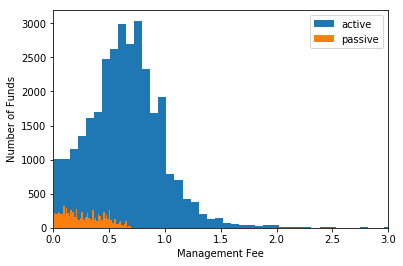

In [250]:
pyplot.hist(active_mgmt, bins = 500, label='active')
pyplot.hist(pass_mgmt, bins = 500, label='passive')
pyplot.xlabel('Management Fee')
pyplot.ylabel('Number of Funds')
pyplot.legend(loc='upper right')
pyplot.xlim(0,3)
pyplot.show()

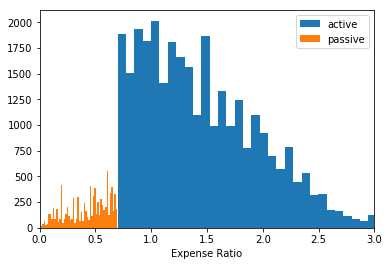

In [243]:
pyplot.hist(active_exp, bins = 700, label='active')
pyplot.hist(pass_exp, bins = 50, label='passive')
pyplot.xlabel('Expense Ratio')
pyplot.ylabel('Number of Funds')
pyplot.legend(loc='upper right')
pyplot.xlim(0,3)
pyplot.show()